In [1]:
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import nltk
import gc
import swifter
from sklearn.feature_extraction.text import TfidfVectorizer
import os
import gensim
from sklearn.decomposition import LatentDirichletAllocation
import pyLDAvis.sklearn
import sklearn 
import gensim
import warnings
import pickle5 as pickle
warnings.filterwarnings('ignore')

%matplotlib inline
pyLDAvis.enable_notebook()

In [2]:
df_narr = pd.read_csv('/Users/kagenlim/Downloads/data_files/narratives.csv')

In [3]:
df_narr.shape

(657719, 20)

In [4]:
df_narr.head()

,Unnamed: 0,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID,Complaint length
0,0,2019-09-24,Debt collection,I do not know,Attempts to collect debt not owed,Debt is not yours,"['transworld', 'system', 'inc', 'try', 'collec...",NaN,TRANSWORLD SYSTEMS INC,FL,335XX,NaN,Consent provided,Web,2019-09-24,Closed with explanation,Yes,NaN,3384392,18
1,1,2019-11-08,Debt collection,I do not know,Communication tactics,Frequent or repeated calls,"['past', 'week', 'receive', 'excessive', 'amou...",NaN,"Diversified Consultants, Inc.",NC,275XX,NaN,Consent provided,Web,2019-11-08,Closed with explanation,Yes,NaN,3433198,78
2,2,2019-09-15,Debt collection,Other debt,Attempts to collect debt not owed,Debt was result of identity theft,"['pioneer', 'commit', 'several', 'federal', 'v...",NaN,Pioneer Capital Solutions Inc,CA,925XX,NaN,Consent provided,Web,2019-09-15,Closed with explanation,Yes,NaN,3374555,152
3,3,2019-07-26,"Credit reporting, credit repair services, or o...",Credit reporting,Problem with a credit reporting company's inve...,Their investigation did not fix an error on yo...,"['previously', 'request', 'experian', 'send', ...",Company has responded to the consumer and the ...,Experian Information Solutions Inc.,CA,914XX,NaN,Consent provided,Web,2019-07-26,Closed with explanation,Yes,NaN,3319331,171
4,4,2019-07-08,"Credit reporting, credit repair services, or o...",Credit reporting,Problem with a credit reporting company's inve...,Their investigation did not fix an error on yo...,"['hello', 'complaint', 'three', 'credit', 'rep...",Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",NY,109XX,NaN,Consent provided,Web,2019-07-08,Closed with explanation,Yes,NaN,3299394,428


In [5]:
narr_file_read = pd.read_csv('/Users/kagenlim/Downloads/data_files/narratives.csv', usecols=['Consumer complaint narrative'], converters={'Consumer complaint narrative': eval}, chunksize=10000, iterator=True)
stringed = pd.Series(dtype='string')

for chunk in tqdm(narr_file_read):
    stringed = stringed.append(chunk['Consumer complaint narrative'].swifter.progress_bar(False).apply(lambda x: [' '.join(x)]))

In [6]:
stringed = pd.Series([string[0] for string in stringed])

In [7]:
for sentence in stringed.values:
    print(sentence)
    print(type(sentence))
    break

transworld system inc try collect debt mine owe inaccurate
<class 'str'>


In [8]:
df_narr['Consumer complaint narrative'] = stringed.values

In [9]:
del stringed
del chunk
gc.collect()

149

In [10]:
df_narr['Consumer complaint narrative'].iloc[100]

'hi send letter deliver request information report error response receive back company disheartening feel like take advantage company credit bureau go month try fix issue everyone simply ignore disregard request letter send clearly state exactly need prove information may report error however simply reply back state request anything specific prove claim attach letter send request inside letter also response letter come month half later company reputation illegal loan shark transaction account set ridiculous late fee billing cycle set increase likelihood miss payment wit end situation need resolve immediately'

## Some Distributions Time-Series

In [11]:
df_narr.columns

Index(['Unnamed: 0', 'Date received', 'Product', 'Sub-product', 'Issue',
       'Sub-issue', 'Consumer complaint narrative', 'Company public response',
       'Company', 'State', 'ZIP code', 'Tags', 'Consumer consent provided?',
       'Submitted via', 'Date sent to company', 'Company response to consumer',
       'Timely response?', 'Consumer disputed?', 'Complaint ID',
       'Complaint length'],
      dtype='object')

In [12]:
date_rec = df_narr['Date received']

date_rec

0         2019-09-24
1         2019-11-08
2         2019-09-15
3         2019-07-26
4         2019-07-08
             ...    
657714    2016-07-11
657715    2017-01-24
657716    2015-03-26
657717    2015-12-12
657718    2016-08-09
Name: Date received, Length: 657719, dtype: object

In [14]:
df_narr['date_rec'] = pd.to_datetime(date_rec)

In [15]:
df_narr['year'] = pd.DatetimeIndex(df_narr['date_rec']).year
df_narr['month'] = pd.DatetimeIndex(df_narr['date_rec']).month

In [17]:
df_narr.head()

,Unnamed: 0,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,...,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID,Complaint length,date_rec,year,month
0,0,2019-09-24,Debt collection,I do not know,Attempts to collect debt not owed,Debt is not yours,transworld system inc try collect debt mine ow...,NaN,TRANSWORLD SYSTEMS INC,FL,...,Web,2019-09-24,Closed with explanation,Yes,NaN,3384392,18,2019-09-24,2019,9
1,1,2019-11-08,Debt collection,I do not know,Communication tactics,Frequent or repeated calls,past week receive excessive amount telephone c...,NaN,"Diversified Consultants, Inc.",NC,...,Web,2019-11-08,Closed with explanation,Yes,NaN,3433198,78,2019-11-08,2019,11
2,2,2019-09-15,Debt collection,Other debt,Attempts to collect debt not owed,Debt was result of identity theft,pioneer commit several federal violation priva...,NaN,Pioneer Capital Solutions Inc,CA,...,Web,2019-09-15,Closed with explanation,Yes,NaN,3374555,152,2019-09-15,2019,9
3,3,2019-07-26,"Credit reporting, credit repair services, or o...",Credit reporting,Problem with a credit reporting company's inve...,Their investigation did not fix an error on yo...,previously request experian send copy verifiab...,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,CA,...,Web,2019-07-26,Closed with explanation,Yes,NaN,3319331,171,2019-07-26,2019,7
4,4,2019-07-08,"Credit reporting, credit repair services, or o...",Credit reporting,Problem with a credit reporting company's inve...,Their investigation did not fix an error on yo...,hello complaint three credit report company tr...,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",NY,...,Web,2019-07-08,Closed with explanation,Yes,NaN,3299394,428,2019-07-08,2019,7


In [47]:
df_narr['year'].value_counts()

2020    164020
2019    124790
2018    118480
2017    115171
2016     77819
2015     54751
2021      2688
Name: year, dtype: int64

Text(0.5, 0.98, 'Distribution of Complaint Narratives Over Time')

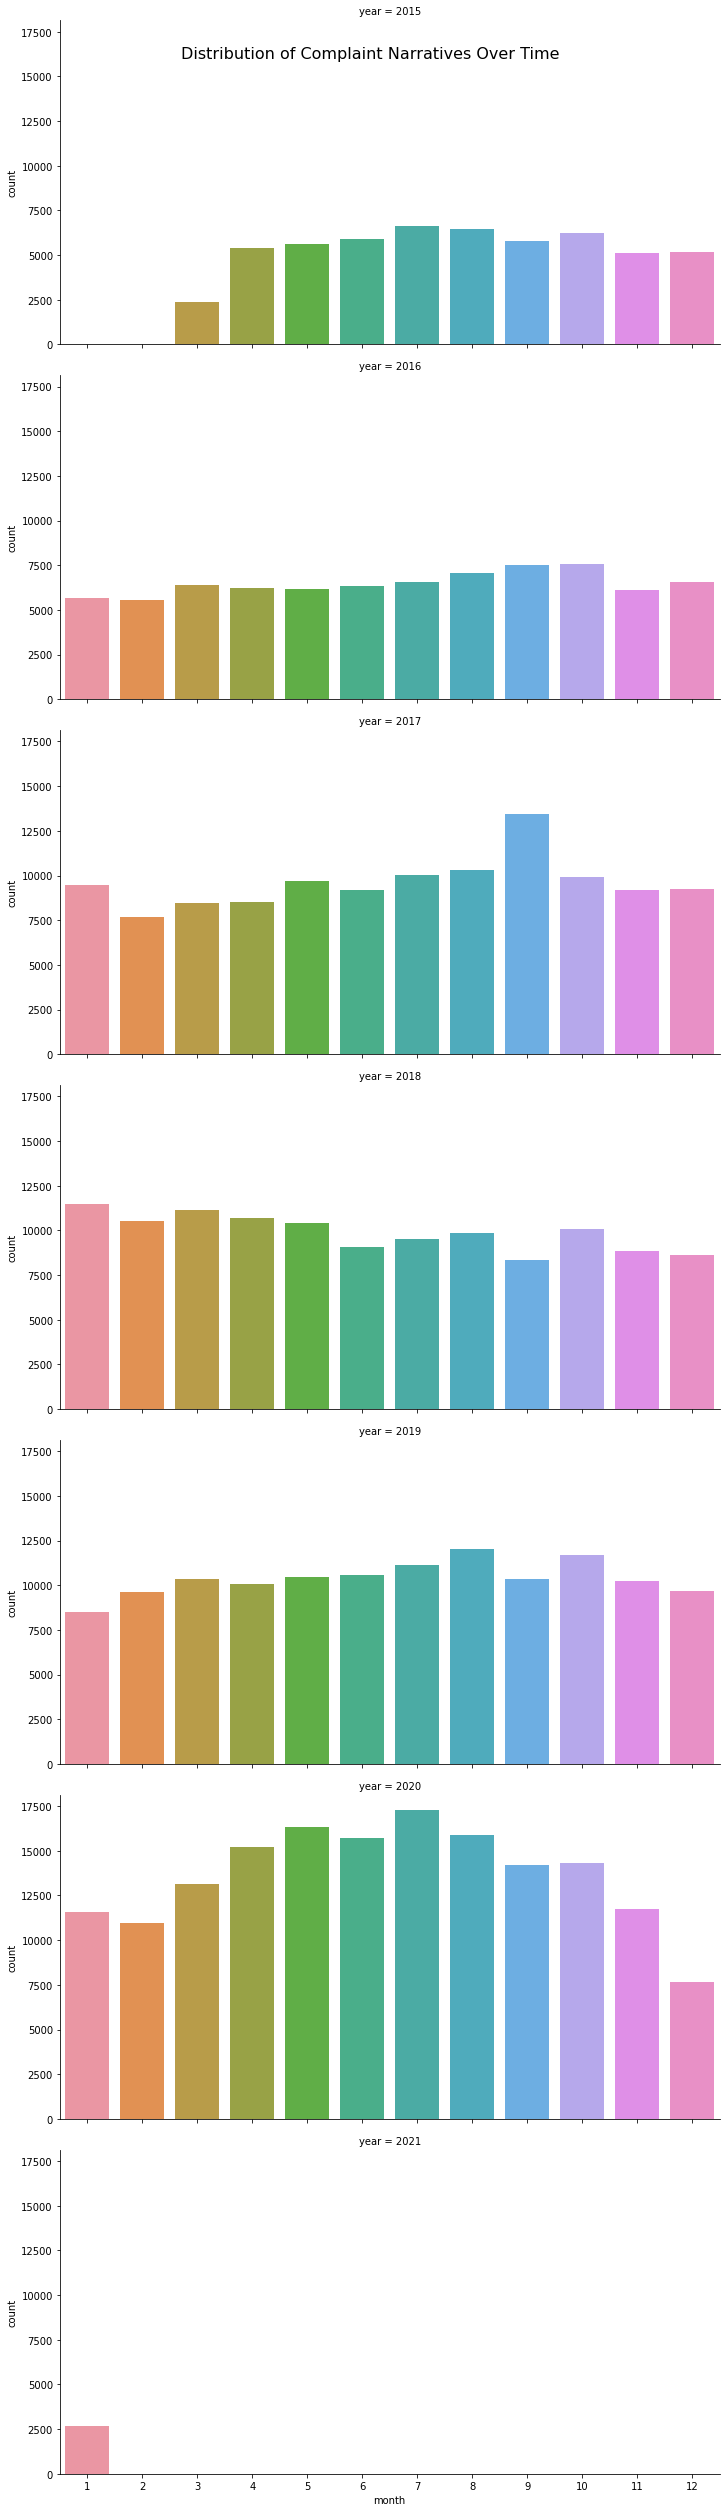

In [64]:
g = sns.catplot(x="month", col = "year", col_wrap = 1,
                 data=df_narr, kind="count", 
                 height = 5, aspect=2)
g.fig.suptitle("Distribution of Complaint Narratives Over Time", fontsize=16)

<AxesSubplot:xlabel='year', ylabel='Issue'>

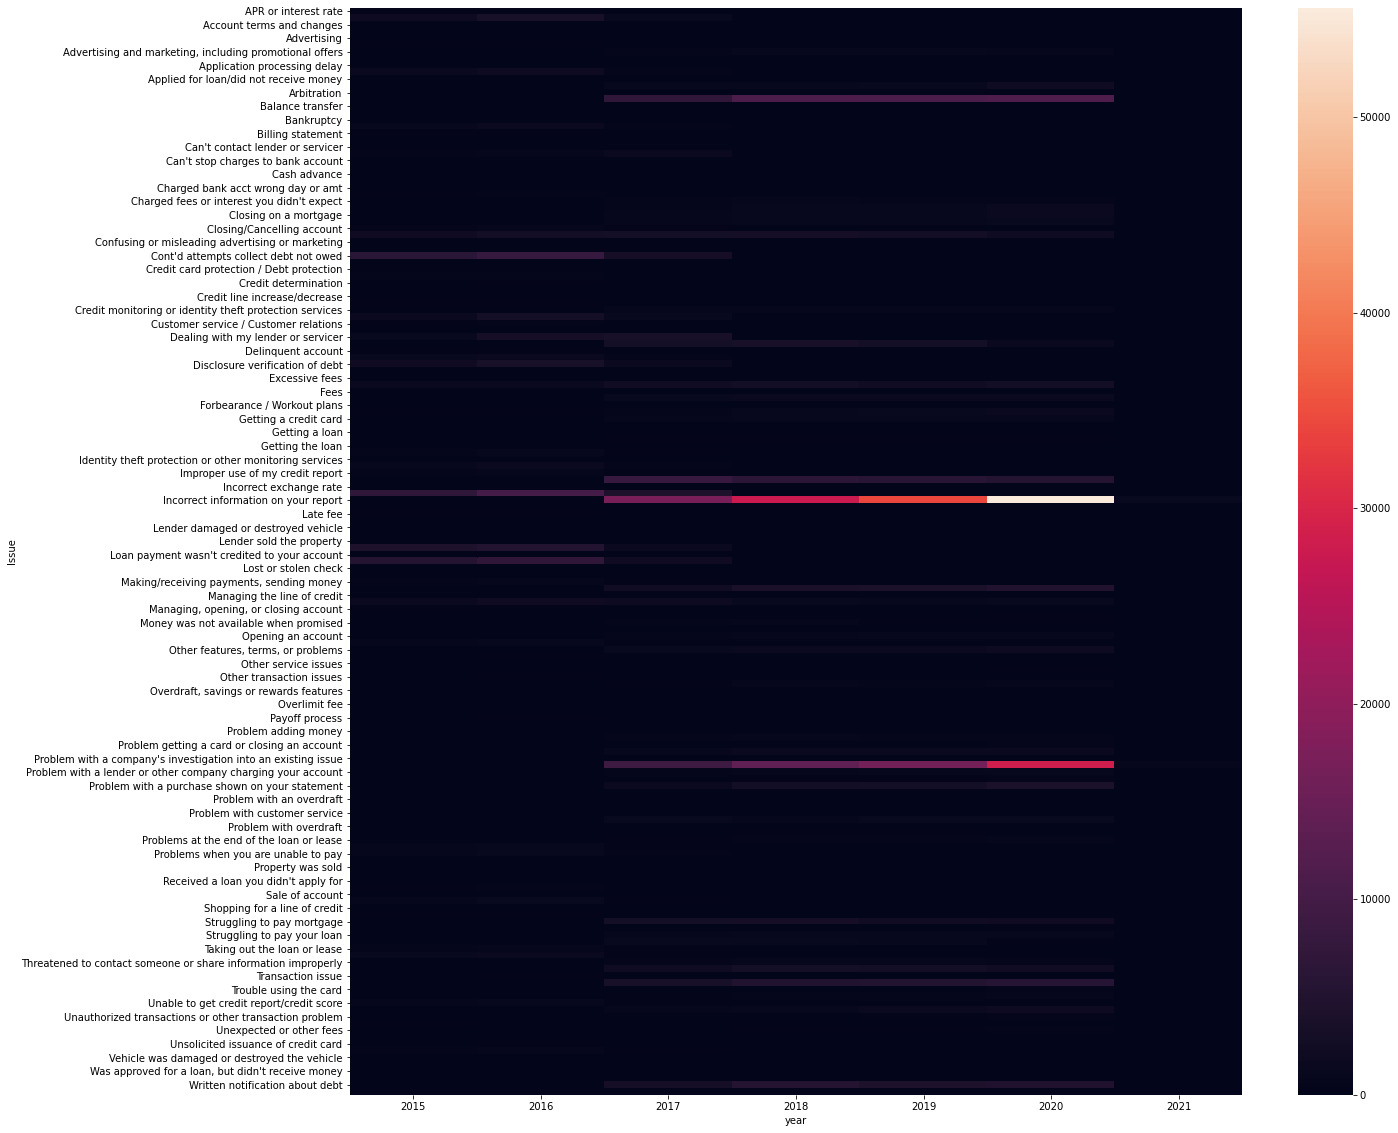

In [42]:
fig, ax = plt.subplots(figsize=(20, 20)) 
sns.heatmap(pd.crosstab(df_narr['Issue'], df_narr['year']), ax = ax)

<AxesSubplot:xlabel='year', ylabel='Company public response'>

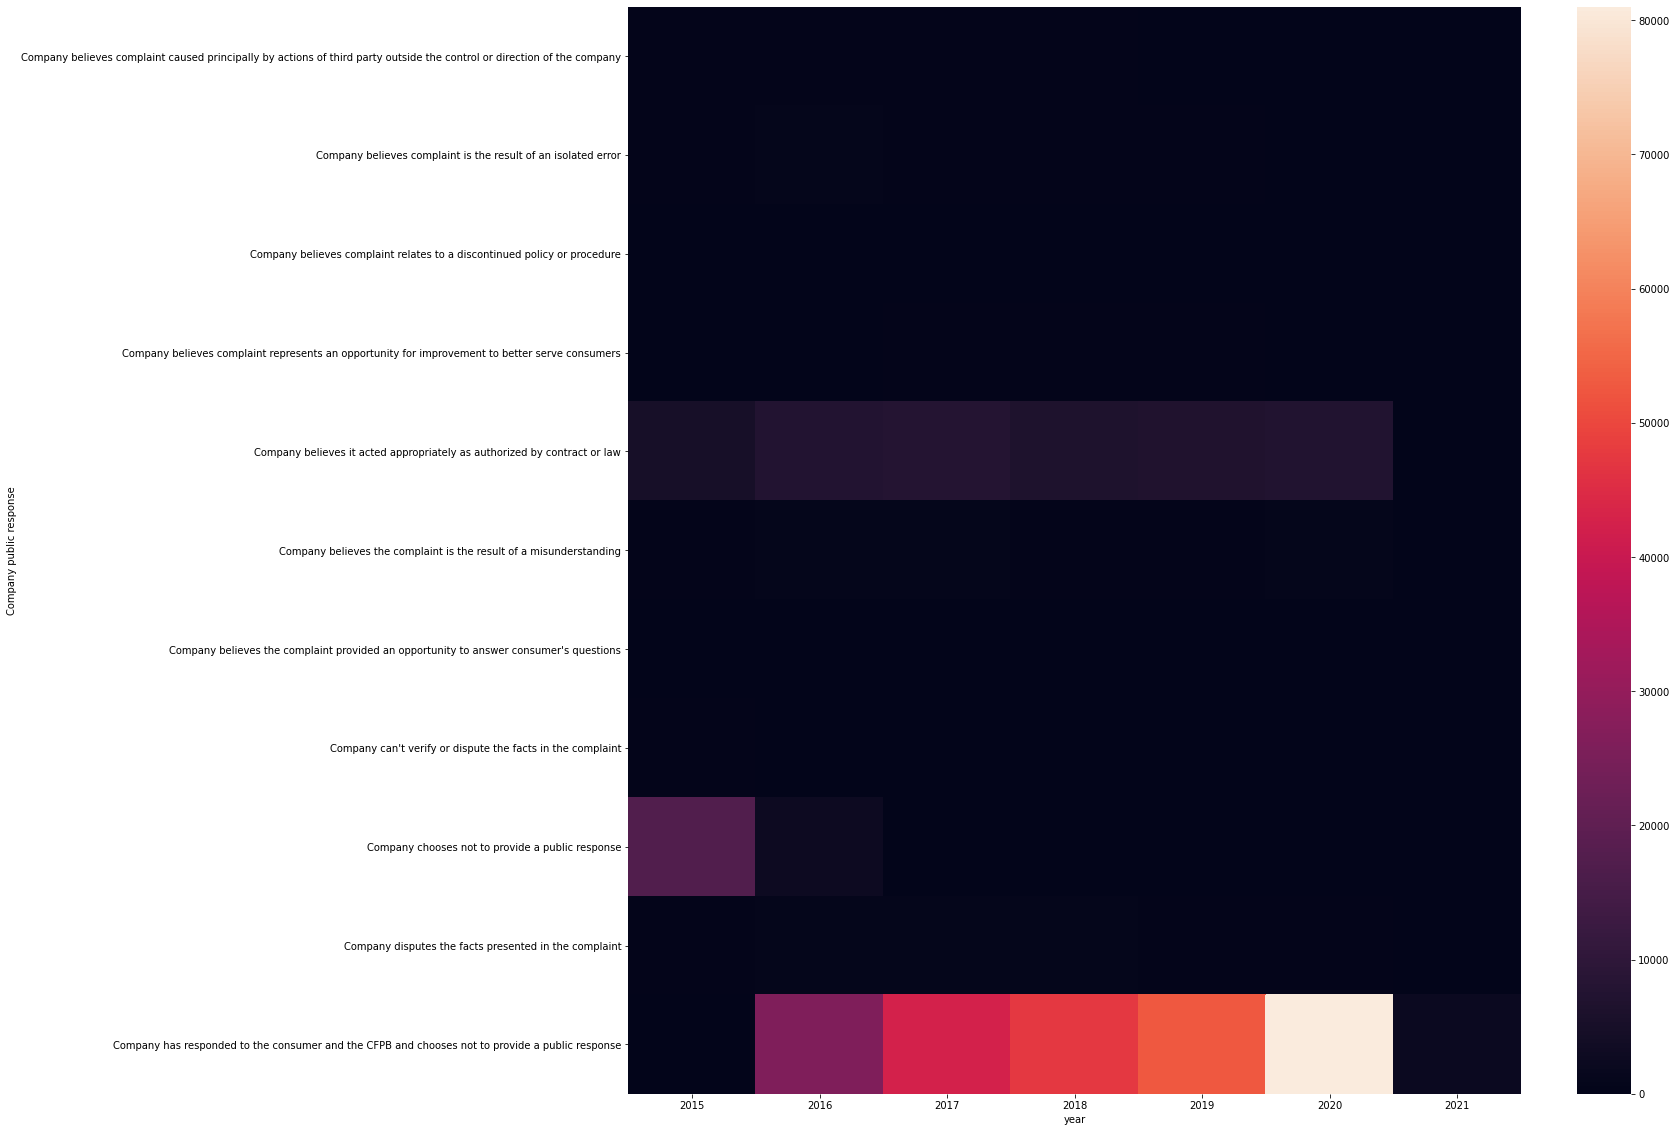

In [43]:
fig, ax = plt.subplots(figsize=(20, 20)) 
sns.heatmap(pd.crosstab(df_narr['Company public response'], df_narr['year']), ax = ax)

<AxesSubplot:xlabel='year', ylabel='State'>

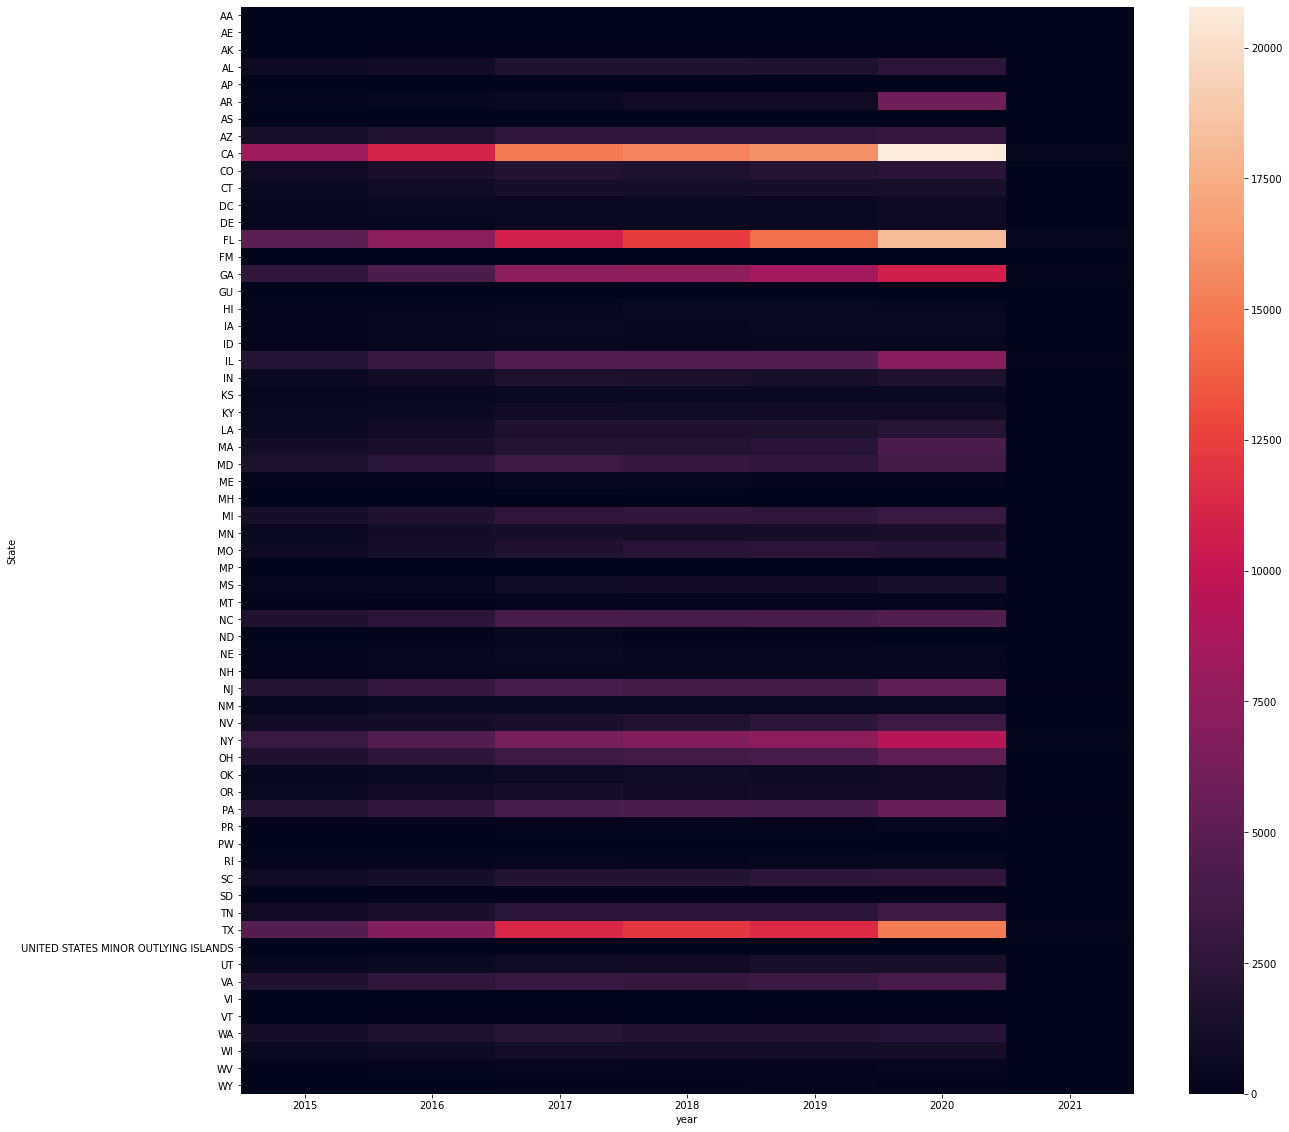

In [44]:
fig, ax = plt.subplots(figsize=(20, 20)) 
sns.heatmap(pd.crosstab(df_narr['State'], df_narr['year']), ax = ax)

<AxesSubplot:xlabel='year', ylabel='Product'>

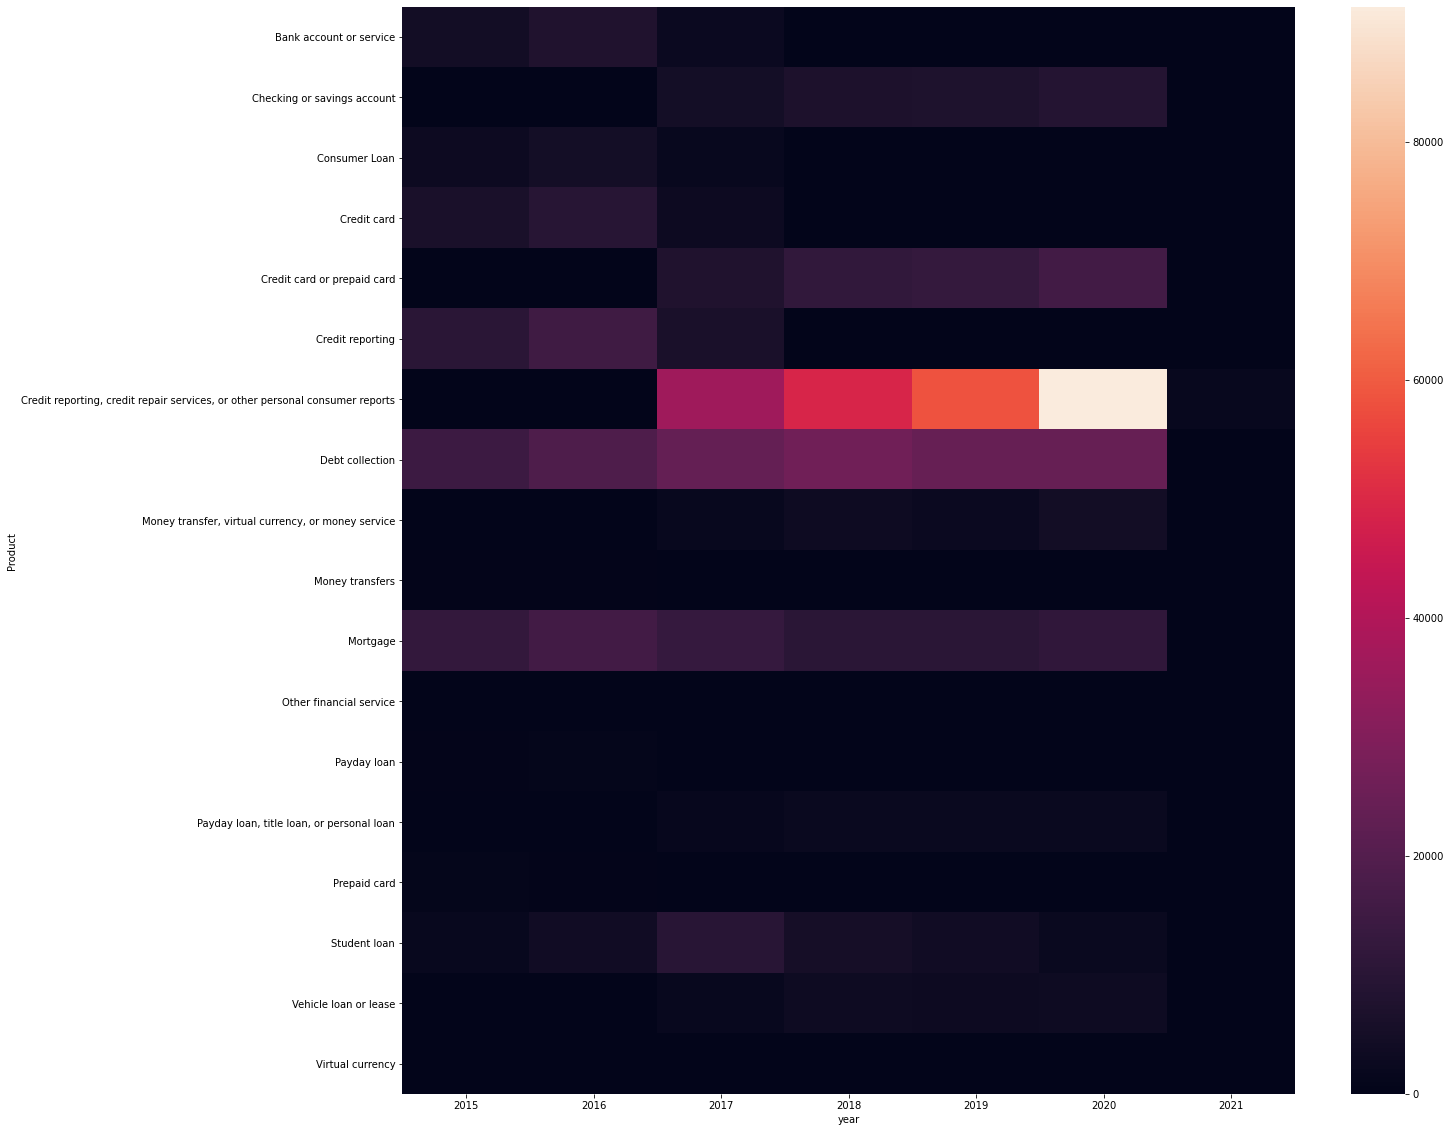

In [45]:
fig, ax = plt.subplots(figsize=(20, 20)) 
sns.heatmap(pd.crosstab(df_narr['Product'], df_narr['year']), ax = ax)

Text(0.5, 0.98, 'Count Plot of Product, Split by Dispute/No Dispute')

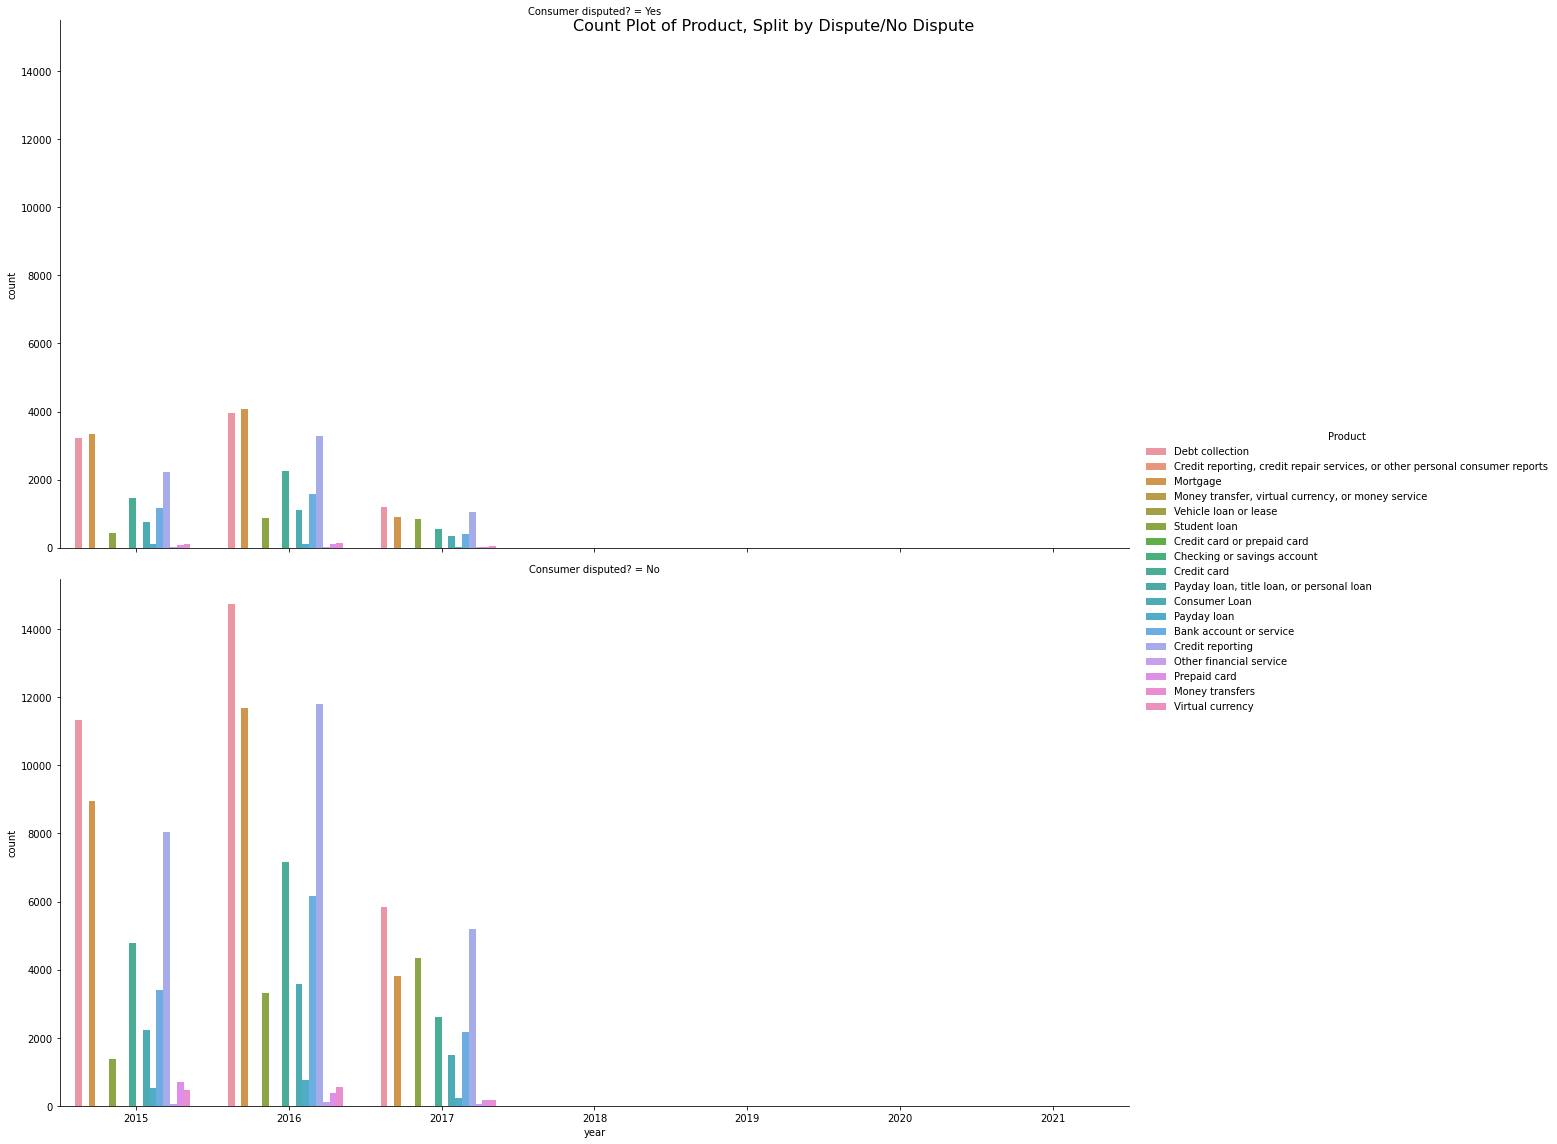

In [62]:
g = sns.catplot(x="year", hue="Product", col = "Consumer disputed?", col_wrap = 1,
                 data=df_narr, kind="count", 
                 height = 8, aspect=2)
g.fig.suptitle("Count Plot of Product, Split by Dispute/No Dispute", fontsize=16)

NameError: name 'p' is not defined

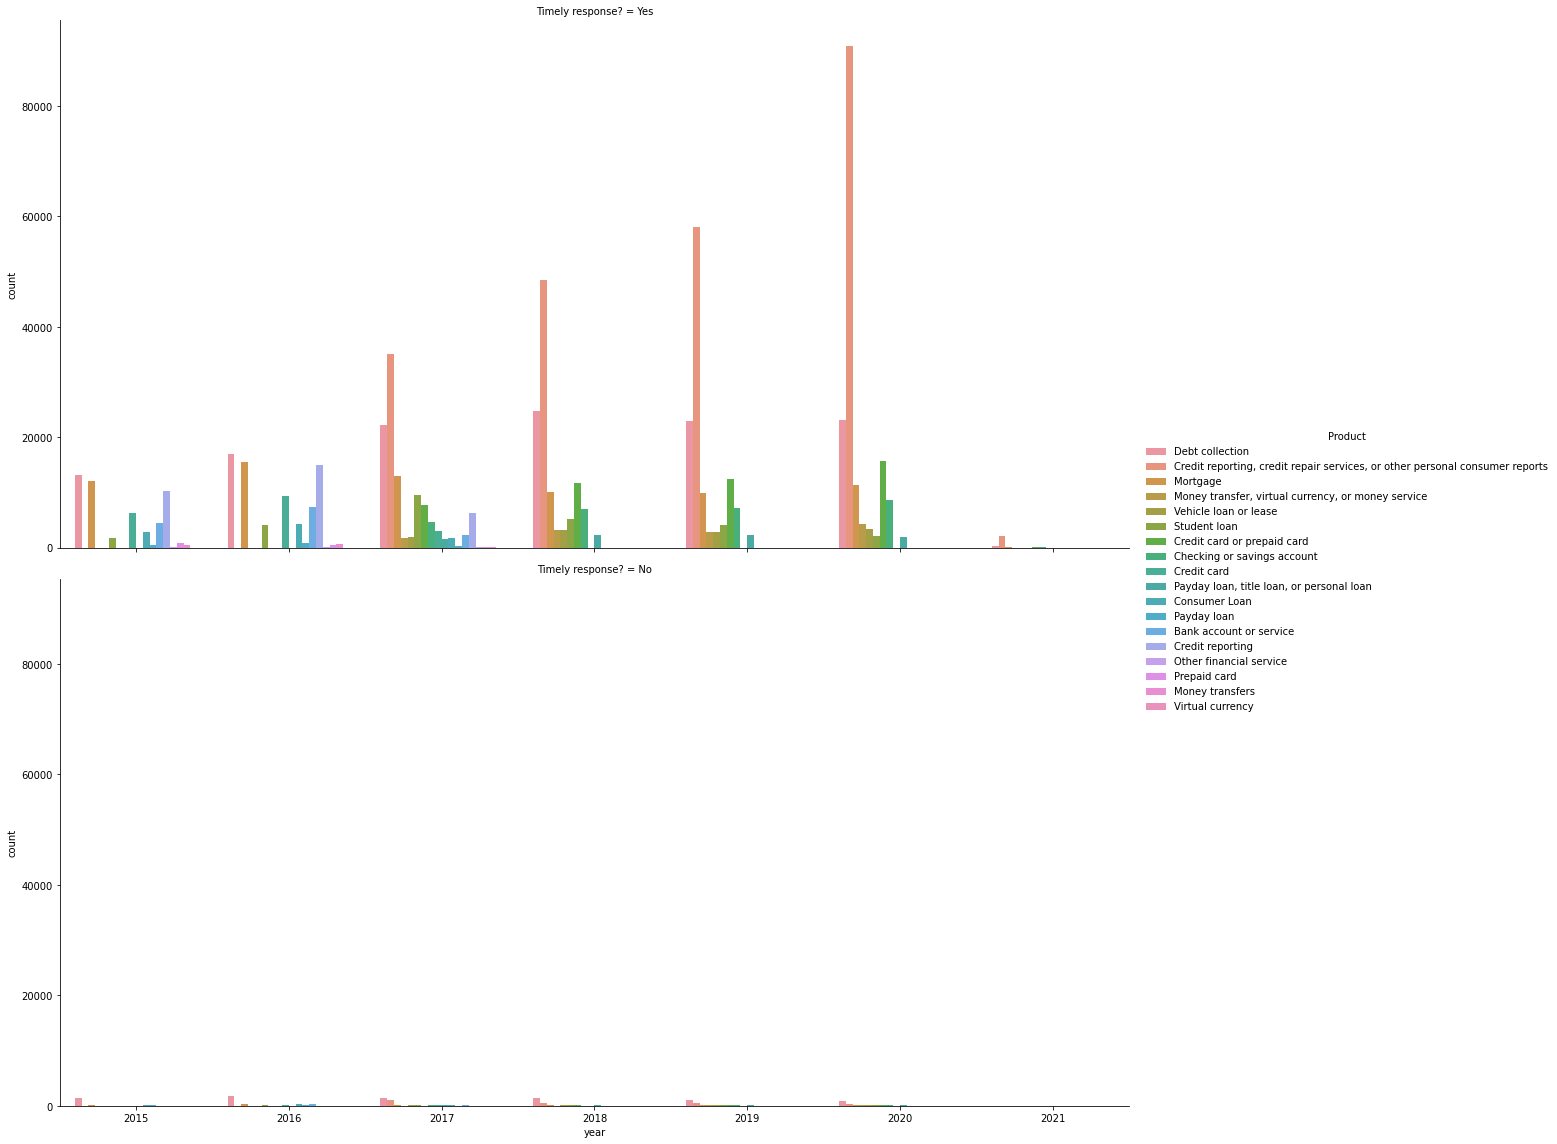

In [63]:
g = sns.catplot(x="year", hue="Product", col = "Timely response?", col_wrap = 1,
                 data=df_narr, kind="count", 
                 height = 8, aspect=2)
p.fig.suptitle("Count Plot of Product, Split by Timely/Not Timely", fontsize=16)